In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import re, nltk
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer        
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
! pip install whoosh
from whoosh import index, writing, scoring
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
import os, os.path
import shutil
from collections import Counter
import string
!pip install wordcloud
from wordcloud import WordCloud
import seaborn as sns
#################################################################
from html.parser import HTMLParser

#download resources
nltk.download('stopwords')
nltk.download('punkt')

C:\Users\Michael\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

# 1. Data cleaning 

The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’. Therefore, the first step is to “clean” the data. Design a procedure that prepares the Twitter data for analysis by satisfying the requirements below. 
* All html tags and attributes (i.e., /<[^>]+>/) are removed. 
* Html character codes (i.e., &...;) are replaced with an ASCII equivalent. 
* All URLs are removed. 
* All characters in the text are in lowercase. 
* All stopwords are removed. Be clear in what you consider as a stopword. 
* If a tweet is empty after pre-processing, it should be preserved as such. 

In [2]:
file = open('unclassified_tweets.txt', "r", encoding = 'utf-8')
origin_tweet = file.readlines()

In [3]:
#remove empty lines in unclassified_tweets.txt
for tw in origin_tweet:
    if len(tw) < 2 or tw =='':
        origin_tweet.remove(tw)
for tw in origin_tweet:
    if len(tw) < 2 or tw =='':
        origin_tweet.remove(tw)

In [4]:
def DataProcessor (filename):
    """
    The function is used to process the data to clean to lower noise such as html tags/attributes, html character codes,
    URLs, upper case words, and stopwords
    """
    filename = filename
    file = open(filename, "r", encoding = 'utf-8')
    file_list = file.readlines()
    
    stop_words = stopwords.words("english") + ['cdnpoli','elxn42','retweeted']
    
    for i in range(len(file_list)):
        # remove html tags
        cleanr = re.compile('<.*?>')
        file_list[i] = re.sub(cleanr, '', file_list[i]) 
        
        #replace html character codes
        parser = HTMLParser()
        html_decoded_string = parser.unescape(file_list[i])
        file_list[i] = html_decoded_string
        
        #remove urls
        file_list[i] = re.sub('(\s+\S+.[^\s]+/\S+)','',file_list[i])
        file_list[i] = re.sub('(\s+\S+.ca)','',file_list[i])
        file_list[i] = re.sub('(\s+\S+.uk)','',file_list[i])
        
        #remove \xa0
        temp_file = re.sub('\xa0','',file_list[i])
        file_list[i] = temp_file
        
        #remove \ufeffl
        temp_file = re.sub('\ufeff','',file_list[i])
        file_list[i] = temp_file
        
        #lowercase characters
        file_list[i] = file_list[i].lower()
        
        #remove punctuation
        tokenizer = RegexpTokenizer(r'\w+')
        file_list[i] = tokenizer.tokenize(file_list[i])
        
        #remove stopwords
        cleaned_text = list(filter(lambda x: x not in stop_words, file_list[i]))
        file_list[i] = cleaned_text
        file_list[i] = " ".join(file_list[i])
    return file_list

In [5]:
unclassified_tw_list = DataProcessor ('unclassified_tweets.txt')

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [6]:
#remove empty lines 
def remove_empty_lines(lst):
    for tw in lst:
        if tw == '':
            lst.remove(tw)
    for tw in lst:
        if tw == '':
            lst.remove(tw)
    return lst

In [7]:
unclassified_tw_list = remove_empty_lines(unclassified_tw_list)

###### Import classified data

In [8]:
# import classified_tweets.txt file as a dataframe
class_filename = "classified_tweets.txt"
classified_tweets_df = pd.read_csv(class_filename, sep=',')

In [9]:
classified_tweets_df.head(10)

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [10]:
classified_tweets_df.to_csv('classified_tweets_only.txt', sep = ',', columns = classified_tweets_df.iloc[:,-1:], header = False, index = False)

In [11]:
classified_tw_list = DataProcessor ('classified_tweets_only.txt')

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


# 2. Exploratory analysis 

In [12]:
def party_name(tw_list):
    '''
    The function take takes a single tweet as imput and analyze the keyword in it. 
    It compares the word frequency of each tweet in the key word list for each party.
    The output is the politican party name of the single twitter. 
    If a tweet is identified as more than one party attribute, it choose the most common party names.
    '''
    tw = tw_list
    # keywords of each party
    liberal =['trudeau', "justin", "justintrudeau", "liberal","liberals","realchange","red","teamtrudeau","lpc","real change"] #defining parties
    conservative=["harper", "steven", "conservative","stiven","blue", "conservatives","cpc"]
    NDP=["ndp","orange","quebec","tommulcair","mulcair","ptndp","ready4change"]
    other = ["green","freedom"]
    # we only defined words in lowercase format, since all words in tweet line are converted to lowercase
    a = []
        
    for word in liberal:   
        if word in tw:
            a.append('Liberal')
        
    for word in conservative:
        if word in tw:
            a.append('Conservative')
           
    for word in NDP:
        if word in tw:
            a.append('NDP')
            
    for word in other:
        if word in tw:
            a.append('Other')
    # choose the most common party name for this tweet
    if len(a) > 1:
        most_common = max(set(a), key=a.count)
        a = []
        a.append(most_common)
    elif len(a) == 0:
        a.append('Other')
        
    return a

### Unclassified Tweets Party Recognition

In [13]:
# put each tweet in to corresponding party list
unclass_party_list = []
unclass_liberal_tweet = []
unclass_conservative_tweet = []
unclass_ndp_tweet = []
for i in range(len(unclassified_tw_list)):   
    party_determinant = party_name(unclassified_tw_list[i])[0]
    unclass_party_list.append(party_determinant)
    if party_determinant == 'Liberal':
        unclass_liberal_tweet.append(unclassified_tw_list[i])
    elif party_determinant == 'Conservative':
        unclass_conservative_tweet.append(unclassified_tw_list[i])
    elif party_determinant == 'NDP':
        unclass_ndp_tweet.append(unclassified_tw_list[i])

Text(0.5,1,'Distribution of the Political Affliation of the Tweets')

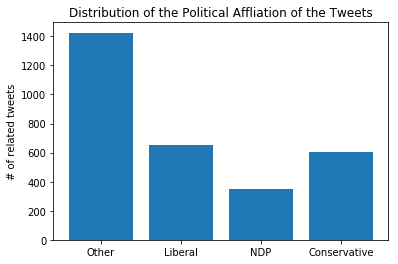

In [14]:
# plot a histogram
x = Counter(unclass_party_list)
l = range(len(x.keys()))
plt.bar(l, x.values(), align='center')
plt.xticks(l, x.keys())
plt.ylabel('# of related tweets')
plt.title('Distribution of the Political Affliation of the Tweets')

The distribution results of unclassified tweets demonstrate that most of tweets are identified as other since they don't contain any of the keyword in the list. Number of tweets about Liberal and Conservative are close since they are two competitive parties in Canada.  

In [15]:
# split a list containing tweets into a list containing words
def split_list_into_word(lst):
    party_word_list = []
    templist = []
    for i in range(len(lst)):
        templist = lst[i].split()
        for word in templist:
            party_word_list.append(word)
    return party_word_list

###### Bonus: WordCloud --- Unclassified Tweets about Liberal

In [16]:
unclass_liberal_wordlist = split_list_into_word(unclass_liberal_tweet)

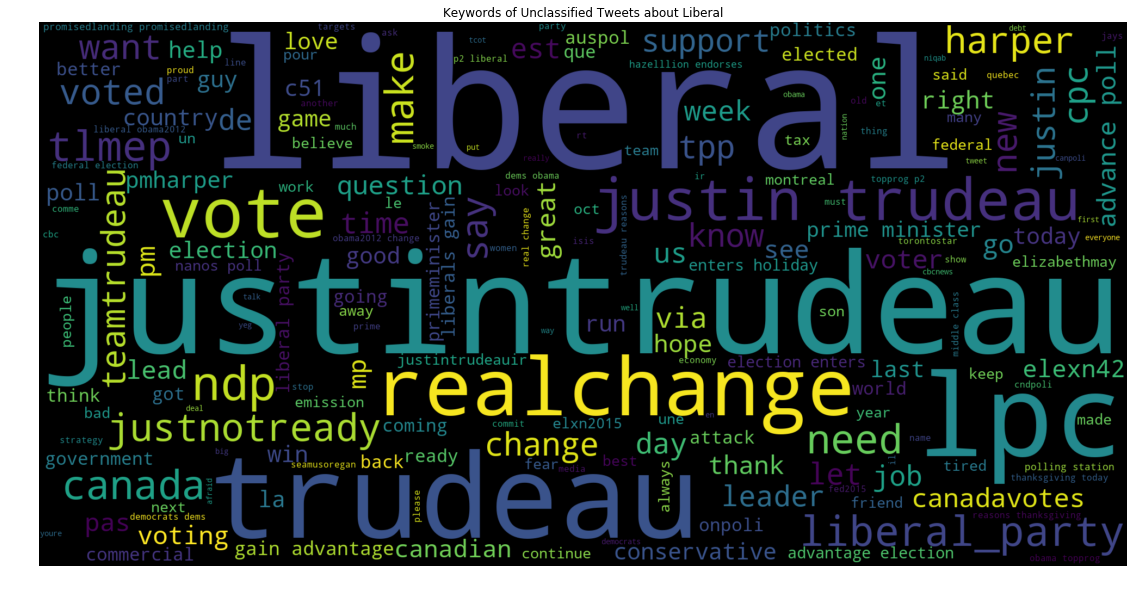

In [69]:
wl_space_split = " ".join(unclass_liberal_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Liberal')
plt.axis("off")
plt.show()

###### Bonus: WordCloud --- Unclassified Tweets about Conservative

In [18]:
unclass_conservative_wordlist = split_list_into_word(unclass_conservative_tweet)

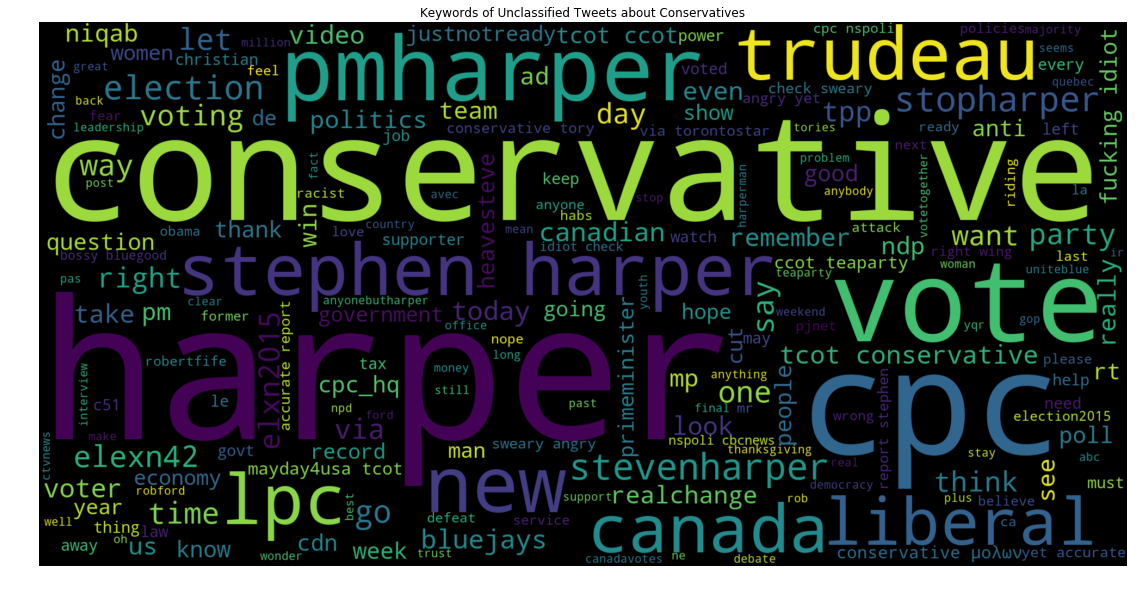

In [71]:
wl_space_split = " ".join(unclass_conservative_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Conservatives')
plt.axis("off")
plt.show()

###### Bonus: WordCloud --- Unclassified Tweets about NDP

In [20]:
unclass_ndp_wordlist = split_list_into_word(unclass_ndp_tweet)

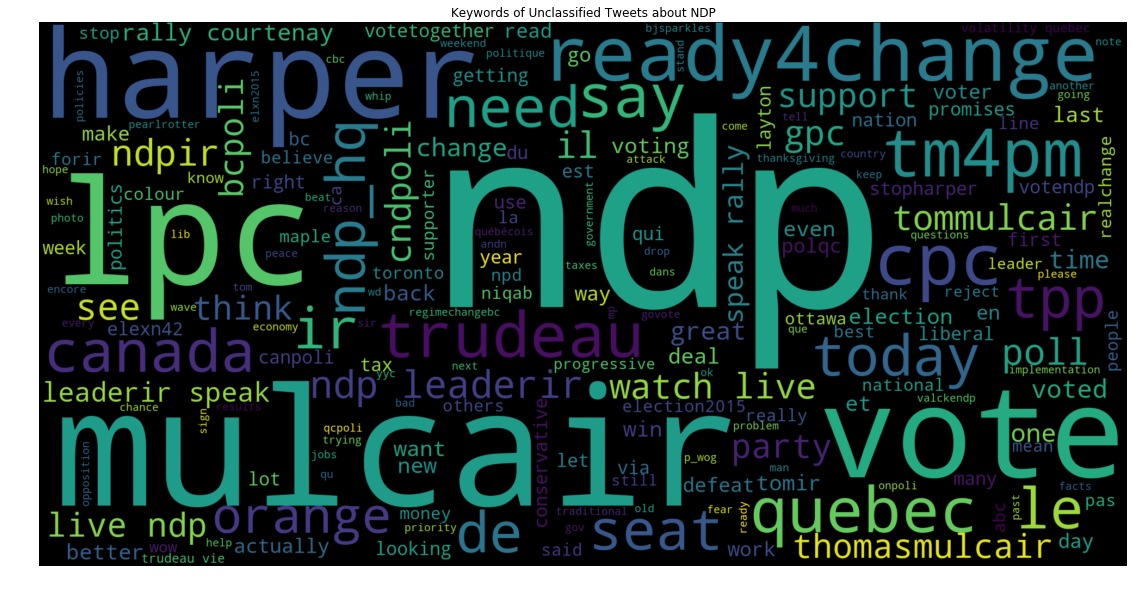

In [72]:
wl_space_split = " ".join(unclass_ndp_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about NDP')
plt.axis("off")
plt.show()

### Classified Tweets Party Recognition

In [22]:
class_party_list = []
class_liberal_tweet = []
class_conservative_tweet = []
class_ndp_tweet = []
for i in range(len(classified_tw_list)):   
    party_determinant = party_name(classified_tw_list[i])[0]
    class_party_list.append(party_determinant)
    if party_determinant == 'Liberal':
        class_liberal_tweet.append(classified_tw_list[i])
    elif party_determinant == 'Conservative':
        class_conservative_tweet.append(classified_tw_list[i])
    elif party_determinant == 'NDP':
        class_ndp_tweet.append(classified_tw_list[i])

Text(0.5,1,'Distribution of the Political Affliation of the Tweets')

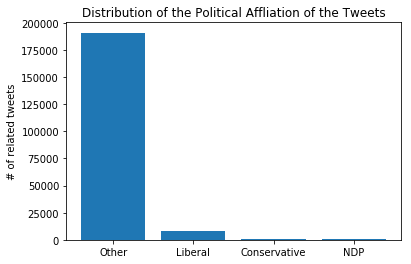

In [23]:
x = Counter(class_party_list)
l = range(len(x.keys()))
plt.bar(l, x.values(), align='center')
plt.xticks(l, x.keys())
plt.ylabel('# of related tweets')
plt.title('Distribution of the Political Affliation of the Tweets')

The distribution results of classified tweets is less meaningful than unclassified tweets since more than 180k tweets were identified as other. The word cloud plots below give more insights.

In [24]:
classified_tweets_df = classified_tweets_df.assign(Party = class_party_list)

In [65]:
classified_tweets_df.head()

,class,id,date,query,user,text,Party
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Other
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Other
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Other
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Other
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Other


###### Bonus: WordCloud --- Classified Tweets about Liberal

In [26]:
class_liberal_wordlist = split_list_into_word(class_liberal_tweet)

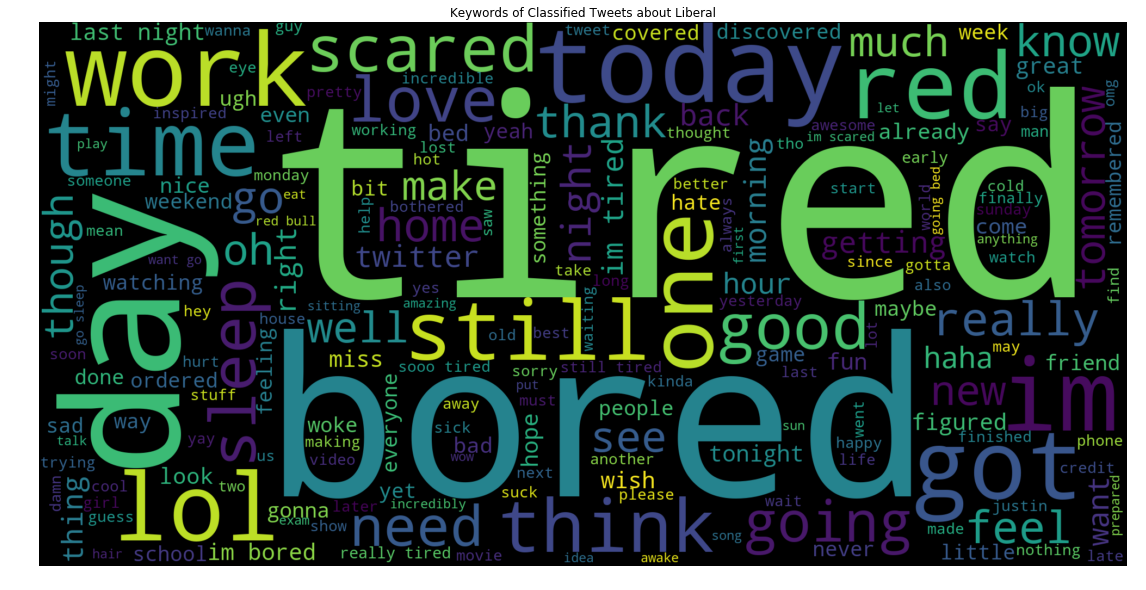

In [73]:
wl_space_split = " ".join(class_liberal_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Classified Tweets about Liberal')
plt.axis("off")
plt.show()

###### Bonus: WordCloud --- Classified Tweets about Conservative

In [28]:
class_conservative_wordlist = split_list_into_word(class_conservative_tweet)

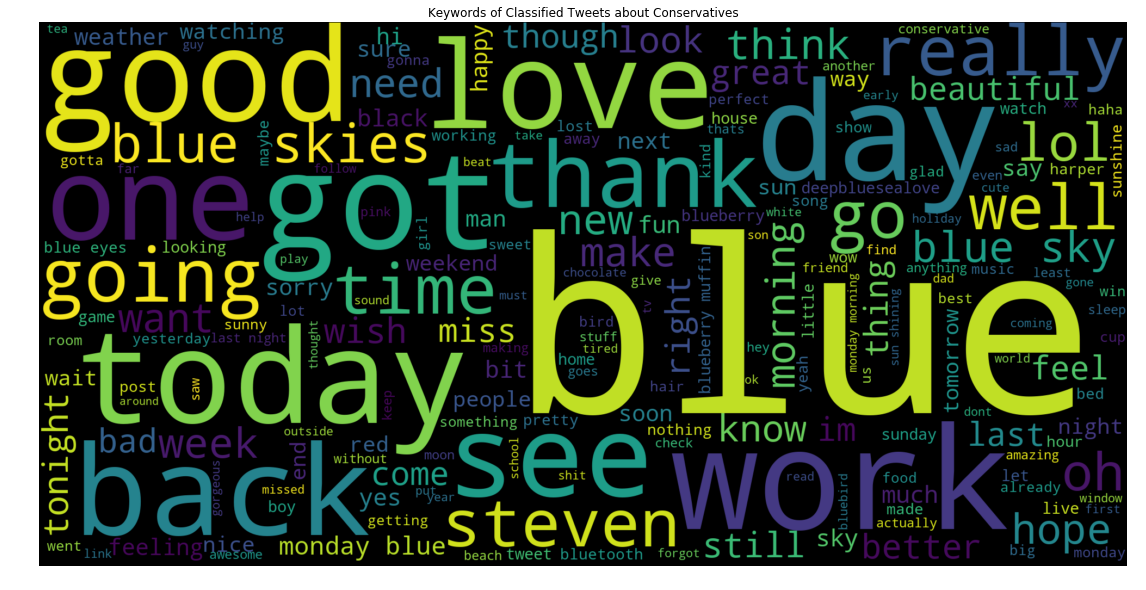

In [74]:
wl_space_split = " ".join(class_conservative_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Classified Tweets about Conservatives')
plt.axis("off")
plt.show()

###### Bonus: WordCloud --- Classified Tweets about NDP

In [30]:
class_ndp_wordlist = split_list_into_word(class_ndp_tweet)

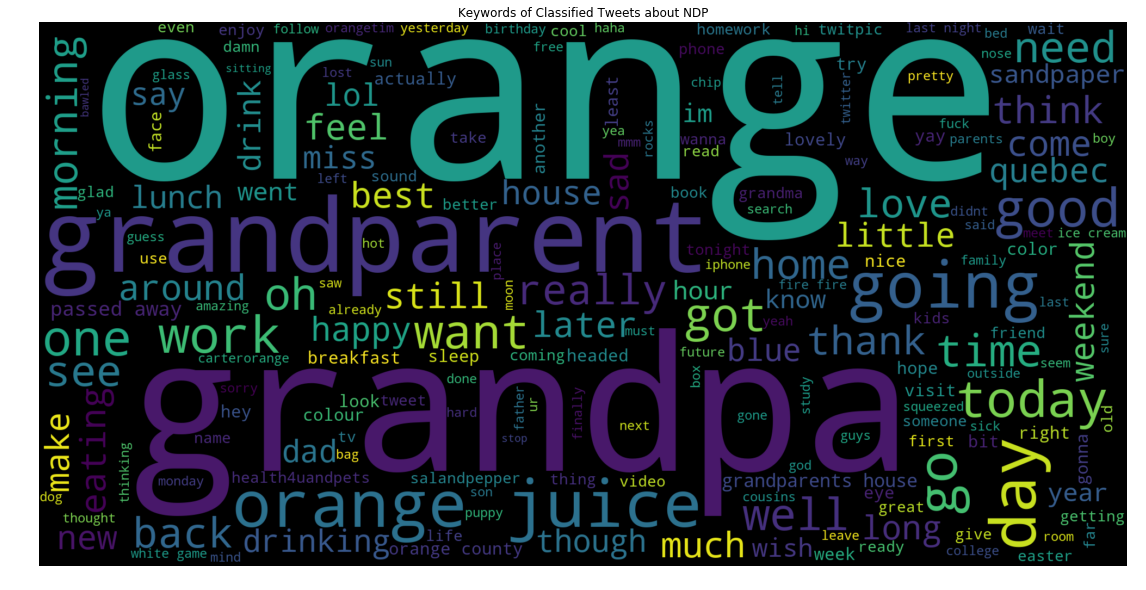

In [75]:
wl_space_split = " ".join(class_ndp_wordlist)
wordcloud = WordCloud(width = 2000, height = 1000).generate(wl_space_split)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Classified Tweets about NDP')
plt.axis("off")
plt.show()

# 3. Model preparation

In [32]:
classified_tweets_df.head()

,class,id,date,query,user,text,Party
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Other
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Other
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Other
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Other
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Other


In [33]:
def cleantw_data_processor(filename, k):
    '''
    The function takes a list as input and count the word frequency of top k word in the list.
    Additionally, it also counts the word frequency in each element in the list. 
    The return result is a dataframe with word frequency and sentiment(target).
    '''
    counter = Counter()
    
    for i in range(len(filename)):
        counter.update([word for word in re.findall(r'\w+', filename[i])]) #if word not in noise_word
        if (i % 50000 == 0):
                print("processed %d tweet" % (i+1))
    # select most frequent k features            
    topk = counter.most_common(k) 
    
    np_array= []
    
    for i in range(len(filename)):
            tempCounter = Counter([word for word in re.findall(r'\w+', filename[i])]) 
            # if the word appears in the doc, then count the frequency, else 0
            topkintweet = [tempCounter[word] if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
            # create a list for top k words with encoded target and its label
            np_array.append(topkintweet+[classified_tweets_df.iloc[:,0][i]])
            if (i % 50000 == 0):
                print("processed %d tweet" % (i+1))
                
    feature_df = pd.DataFrame(np_array)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    feature_df.columns = dfName+['target']
    
    print("Process is done!")
    
    return feature_df
    

In [34]:
class_feature_df = cleantw_data_processor(classified_tw_list,500)

processed 1 tweet
processed 50001 tweet
processed 100001 tweet
processed 150001 tweet
processed 1 tweet
processed 50001 tweet
processed 100001 tweet
processed 150001 tweet
Process is done!


In [35]:
class_feature_df.head()

,good,day,get,like,go,work,today,going,back,love,...,boys,dead,running,ask,sunshine,spring,jealous,movies,cut,target
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
features_df = class_feature_df.iloc[:,:-2]
features = features_df.as_matrix()
target_df = class_feature_df['target']
target = target_df.as_matrix()

In [37]:
#split data ramdomly into training data(70%) and test data(30%)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)

# 4. Model implementation

In [38]:
#Confidence Interval Function
import scipy.stats
from math import sqrt
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    mu,sd = np.mean(a),np.std(a)
    z = scipy.stats.t.ppf(confidence, n)
    h=z*sd/sqrt(n)
    return mu, h

###### Logistic Regression

In [39]:
def Log_Reg(data, num_run, **params):

    train_scores = []
    test_scores = []
    features_df = data.iloc[:,:-2]
    features = features_df.as_matrix()
    target_df = data['target']
    target = target_df.as_matrix()
    
    
    classifier = LogisticRegression(C=params['c'])

    for i in range(num_run):
        #split data ramdomly into training data(70%) and test data(30%)
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify = target)
        clfModel = classifier.fit(features_train, target_train)
        # predict using train data
        train_target_pred = clfModel.predict(features_train)
        # predict using test data
        test_target_pred = clfModel.predict(features_test)
        train_scores.append(metrics.accuracy_score(target_train, train_target_pred))
        test_scores.append(metrics.accuracy_score(target_test, test_target_pred))     
    
    train_mean,train_ci = mean_confidence_interval(train_scores)
    test_mean,test_ci = mean_confidence_interval(test_scores)    
 
    return train_scores,test_scores,train_mean,test_mean,train_ci,test_ci
    

In [40]:
# show result
train_scores,test_scores,train_mean,test_mean,train_ci,test_ci = Log_Reg(class_feature_df, 10, c=1.0)
print("Train\
    \nResult of trials:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(train_scores, train_mean, train_ci)
     )
print("Test\
    \nResult of trials:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(test_scores, test_mean, test_ci)
     )

Train    
Result of trials:[0.71782142857142861, 0.71831428571428568, 0.71932142857142856, 0.71862142857142852, 0.71822857142857144, 0.71745000000000003, 0.71829285714285718, 0.71883571428571424, 0.71905714285714284, 0.72005714285714284]     
Average Accuracy: 0.7185999999999999     
Confidence Interval: 0.0004113658539565706

Test    
Result of trials:[0.71708333333333329, 0.71586666666666665, 0.71525000000000005, 0.71575, 0.71623333333333339, 0.71865000000000001, 0.71718333333333328, 0.71653333333333336, 0.71516666666666662, 0.71331666666666671]     
Average Accuracy: 0.7161033333333333     
Confidence Interval: 0.0007767405705790541


###### Bonus: Training with k-Fold Cross-Validation

In [41]:
def K_Fold_Log_Reg(data, num_run, **params):
    
    train_scores = []
    test_scores = []
    features_df = data.iloc[:,:-2]
    features = features_df.as_matrix()
    target_df = data['target']
    target = target_df.as_matrix()
    
    classifier = LogisticRegression(C=params['c'])
    cv = StratifiedKFold(target, n_folds=10)
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify = target)

    for i, (train, test) in enumerate(cv):
        clfModel = classifier.fit(features_train, target_train)
        train_target_pred = clfModel.predict(features_train)
        test_target_pred = clfModel.predict(features_test)
        train_scores.append(metrics.accuracy_score(target_train, train_target_pred))
        test_scores.append(metrics.accuracy_score(target_test, test_target_pred))   
    
    train_mean,train_ci = mean_confidence_interval(train_scores)
    test_mean,test_ci = mean_confidence_interval(test_scores)    
    
    return train_scores,test_scores,train_mean,test_mean,train_ci,test_ci
    

In [42]:
train_scores,test_scores,train_mean,test_mean,train_ci,test_ci = K_Fold_Log_Reg(class_feature_df, 10, c=1.0)
print("Train\
    \nResult of trials:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(train_scores, train_mean, train_ci)
     )
print("Test\
    \nResult of trials:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(test_scores, test_mean, test_ci)
     )

Train    
Result of trials:[0.71875714285714287, 0.71875714285714287, 0.71875714285714287, 0.71875714285714287, 0.71875714285714287, 0.71875714285714287, 0.71875714285714287, 0.71875714285714287, 0.71875714285714287, 0.71875714285714287]     
Average Accuracy: 0.7187571428571429     
Confidence Interval: 0.0

Test    
Result of trials:[0.71536666666666671, 0.71536666666666671, 0.71536666666666671, 0.71536666666666671, 0.71536666666666671, 0.71536666666666671, 0.71536666666666671, 0.71536666666666671, 0.71536666666666671, 0.71536666666666671]     
Average Accuracy: 0.7153666666666666     
Confidence Interval: 6.363249170458029e-17


###### Bonus:Naive Bayes

In [43]:
def Nai_Bay(data, num_run):
   
    train_scores = []
    test_scores = []
    features_df = data.iloc[:,:-2]
    features = features_df.as_matrix()
    target_df = data['target']
    target = target_df.as_matrix()
    
    classifier = GaussianNB()
    for i in range(num_run):
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify = target)
        clfModel = classifier.fit(features_train, target_train)
        train_target_pred = clfModel.predict(features_train)
        test_target_pred = clfModel.predict(features_test)
        train_scores.append(metrics.accuracy_score(target_train, train_target_pred))
        test_scores.append(metrics.accuracy_score(target_test, test_target_pred))     
    
    train_mean,train_ci = mean_confidence_interval(train_scores)
    test_mean,test_ci = mean_confidence_interval(test_scores)    

    return train_scores,test_scores,train_mean,test_mean,train_ci,test_ci
    

In [44]:
train_scores,test_scores,train_mean,test_mean,train_ci,test_ci = Nai_Bay(class_feature_df, 10)
print("Train\
    \nResult of trials:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(train_scores, train_mean, train_ci)
     )
print("Test\
    \nResult of trials:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(test_scores, test_mean, test_ci)
     )

Train    
Result of trials:[0.69159285714285712, 0.69151428571428575, 0.6923785714285714, 0.69099999999999995, 0.69155714285714287, 0.69176428571428572, 0.69154285714285713, 0.69138571428571427, 0.69326428571428567, 0.69005714285714281]     
Average Accuracy: 0.6916057142857142     
Confidence Interval: 0.00045135414075966093

Test    
Result of trials:[0.68863333333333332, 0.68666666666666665, 0.68951666666666667, 0.68889999999999996, 0.68823333333333336, 0.68694999999999995, 0.69045000000000001, 0.68969999999999998, 0.68643333333333334, 0.68784999999999996]     
Average Accuracy: 0.6883333333333334     
Confidence Interval: 0.0007407722722975841


###### Testing on Unclassified Tweets

In [45]:
# get unclassified tweets features
unclass_feature_df = cleantw_data_processor(unclassified_tw_list,500)

processed 1 tweet
processed 1 tweet
Process is done!


In [46]:
unclass_feature_df.head()

,harper,ndp,vote,trudeau,added,lpc,justintrudeau,liberal,cpc,conservative,...,angry,anything,trump,middle,pic,patondabak,ontario,andrew,comme,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
def Sentiment_Predict(classified_df, unclassified_df, **params):

    sentiment_list = []
    tweet_list = []
    party_list = unclass_party_list
    
    features_df = classified_df.iloc[:,:-2]
    features = features_df.as_matrix()
    target_df = classified_df['target']
    target = target_df.as_matrix()
    
    predict_features_df = unclassified_df.iloc[:,:-2]
    predict_features = predict_features_df.as_matrix()
        
    classifier = LogisticRegression(C=params['c'])
    
    # predict using classified tweet features
    clfModel = classifier.fit(features, target)
    target_pred = clfModel.predict(predict_features)
    
    for i in range(len(target_pred)):
        sentiment_list.append(target_pred[i])
        tweet_list.append(origin_tweet[i])
        
    analysis = pd.DataFrame({"Sentiment": sentiment_list, "Original Tweets": tweet_list, "Party": party_list})
    
    return analysis

In [48]:
unclassified_tweets_df = Sentiment_Predict(class_feature_df,unclass_feature_df, c=1.0)

In [49]:
# show results of analysis
unclassified_tweets_df.head()

,Original Tweets,Party,Sentiment
0,﻿living the dream. #cameraman #camera #camerac...,Other,4
1,justin #trudeau's reasons for thanksgiving. to...,Liberal,0
2,@themadape butt…..butt…..we’re allergic to l...,Other,4
3,2 massive explosions at peace march in #turkey...,Other,4
4,#mulcair suggests there’s bad blood between hi...,NDP,0


# 5. Discussion 

###### Histogram of sentiment (classified)

In [50]:
classified_tweets_df.head()

,class,id,date,query,user,text,Party
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Other
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Other
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Other
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Other
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Other


In [51]:
classified_liberal_df = classified_tweets_df[classified_tweets_df['Party'].isin(['Liberal'])]
classified_conservative_df = classified_tweets_df[classified_tweets_df['Party'].isin(['Conservative'])]
classified_NDP_df = classified_tweets_df[classified_tweets_df['Party'].isin(['NDP'])]

In [52]:
classified_liberal_df.head()

,class,id,date,query,user,text,Party
71,0,1467825642,Mon Apr 06 22:23:39 PDT 2009,NO_QUERY,timmelko,@ninjen I'm sure you're right... I need to ...,Liberal
90,0,1467835345,Mon Apr 06 22:26:10 PDT 2009,NO_QUERY,RU_it_girl,@Hollywoodheat I should have paid more attenti...,Liberal
109,0,1467838188,Mon Apr 06 22:26:54 PDT 2009,NO_QUERY,jess_higley,@marykatherine_q i know! I heard it this after...,Liberal
130,0,1467841897,Mon Apr 06 22:27:56 PDT 2009,NO_QUERY,aaronrothe,@chelserlynn haha its so cooooold in the d! an...,Liberal
134,0,1467842377,Mon Apr 06 22:28:04 PDT 2009,NO_QUERY,bnr0201,I'm missing you babe.. but as long as your al...,Liberal


In [53]:
# count number of positive/ negartive sentiment for each party
classified_liberal_counts = classified_liberal_df['class'].value_counts().to_dict()
classified_conservative_counts = classified_conservative_df['class'].value_counts().to_dict()
classified_NDP_counts = classified_NDP_df['class'].value_counts().to_dict()

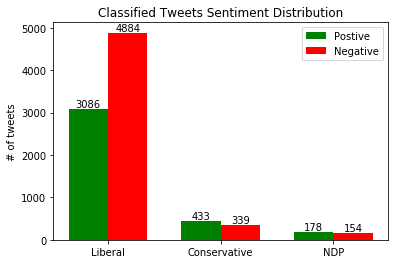

In [66]:
# plot a histogram to show the result of number of positive/ negartive sentiment for each party
N = 3
postive = (classified_liberal_counts[4], classified_conservative_counts[4], classified_NDP_counts[4])
ind = np.arange(N)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind, postive, width, color='g')
negative = (classified_liberal_counts[0], classified_conservative_counts[0], classified_NDP_counts[0])
rects2 = ax.bar(ind + width, negative, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('# of tweets')
ax.set_title('Classified Tweets Sentiment Distribution')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('Liberal', 'Conservative', 'NDP'))

ax.legend((rects1[0], rects2[0]), ('Postive', 'Negative'))

def label(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%d' % int(height),
                ha='center', va='bottom')

label(rects1)
label(rects2)

plt.show()

###### Histogram of sentiment (unclassified)

In [55]:
unclassified_tweets_df.head()

,Original Tweets,Party,Sentiment
0,﻿living the dream. #cameraman #camera #camerac...,Other,4
1,justin #trudeau's reasons for thanksgiving. to...,Liberal,0
2,@themadape butt…..butt…..we’re allergic to l...,Other,4
3,2 massive explosions at peace march in #turkey...,Other,4
4,#mulcair suggests there’s bad blood between hi...,NDP,0


In [56]:
unclassified_liberal_df = unclassified_tweets_df[unclassified_tweets_df['Party'].isin(['Liberal'])]
unclassified_conservative_df = unclassified_tweets_df[unclassified_tweets_df['Party'].isin(['Conservative'])]
unclassified_NDP_df = unclassified_tweets_df[unclassified_tweets_df['Party'].isin(['NDP'])]

In [57]:
unclassified_liberal_counts = unclassified_liberal_df['Sentiment'].value_counts().to_dict()
unclassified_conservative_counts = unclassified_conservative_df['Sentiment'].value_counts().to_dict()
unclassified_NDP_counts = unclassified_NDP_df['Sentiment'].value_counts().to_dict()

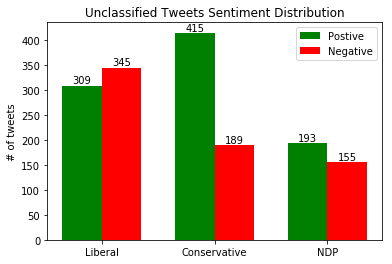

In [67]:
# plot a histogram to show the result of number of positive/ negartive sentiment for each party
N = 3
postive = (unclassified_liberal_counts[4], unclassified_conservative_counts[4], unclassified_NDP_counts[4])
ind = np.arange(N)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind, postive, width, color='g')
negative = (unclassified_liberal_counts[0], unclassified_conservative_counts[0], unclassified_NDP_counts[0])
rects2 = ax.bar(ind + width, negative, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('# of tweets')
ax.set_title('Unclassified Tweets Sentiment Distribution')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('Liberal', 'Conservative', 'NDP'))

ax.legend((rects1[0], rects2[0]), ('Postive', 'Negative'))

def label(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%d' % int(height),
                ha='center', va='bottom')

label(rects1)
label(rects2)

plt.show()

According to the analysis above, Liberal was the most prevailing party on Twitter in both The tweets about Liberal was much more than other two political parties. The sentiment analysis shows a consistent distribution of postive and negative sentiment on all the political parties in both classified tweets and unclassified tweets. More postive sentiment appears in both data set for Conservative and NDP. Contrarily, the negative sentiment on Liberal is more than postive sentiment. The portion of different sentiment are different in classified and unclassified tweets. The sample size of unclassified tweets is a potential explanation about this inconsistence. <br />
<br />
Accoding to CBC News, Liberal, Conservative and New Democratic won 184, 99, 44 seats, respectively. The election results were proportional to the number of tweets in this analysis. Although the analysis results show that Liberal received more negative sentiment, it does't affect the popularity of Justin Trudeau. The results are similar to 2016 U.S. election. Donald Trump won the election regardless that he reveiced much more negative sentiment on twitter. It it more likely for politicians to receive more critisim if they are prevailing. 

# Bonus

###### Tuning Hyperparameter

In [59]:
def hyperParameterAC(data, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
    
    OUTPUT
        test_mean_hp: list.  mean accuracy list of test
        test_ci_hp: list. confidence interval list of test
        train_mean_hp: list. mean accuracy list of train
        train_ci_hp: list. confidence interval list of train
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    params = np.logspace(-4, 4, num=9)
    
    ########### your code goes here ###########

    train_scores = []
    test_scores = []
    train_mean_hp = []
    train_ci_hp = []
    test_mean_hp = []
    test_ci_hp = []
    for i in range(len(params)):
        features_df = data.iloc[:,:-2]
        features = features_df.as_matrix()
        target_df = data['target']
        target = target_df.as_matrix()

        
        if clf == "LR":
            classifier = LogisticRegression(C=params[i])
        elif clf == "NB":
            classifier = GaussianNB()
        
        for j in range(num_run):
            features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify = target)
            clfModel = classifier.fit(features_train, target_train)
            train_target_pred = clfModel.predict(features_train)
            test_target_pred = clfModel.predict(features_test)
            # compute the confusion matrix on each fold, convert it to a DataFrame and stash it for later compute
            # stash the overall accuracy on the test set for the fold too
            train_scores.append(metrics.accuracy_score(target_train, train_target_pred))
            test_scores.append(metrics.accuracy_score(target_test, test_target_pred))     
            
        train_mean,train_ci = mean_confidence_interval(train_scores)
        test_mean,test_ci = mean_confidence_interval(test_scores) 
        train_mean_hp.append(train_mean)
        train_ci_hp.append(train_ci)
        test_mean_hp.append(test_mean)
        test_ci_hp.append(test_ci)

    ###########         end         ###########
    return train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp

In [60]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp = hyperParameterAC(class_feature_df, 'LR', 3)

In [61]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp

([0.68877619047619054,
  0.69539761904761921,
  0.70199444444444448,
  0.70612559523809537,
  0.70864952380952384,
  0.71026428571428579,
  0.71148945578231293,
  0.71248988095238097,
  0.71314576719576717],
 [0.00092058227093145487,
  0.0052667564693196084,
  0.0065952435842376997,
  0.0060586543797420721,
  0.0052869914867604614,
  0.0046015369156626454,
  0.0040731307714877187,
  0.003662741899068029,
  0.0032980223455192975],
 [0.68551666666666655,
  0.69277777777777771,
  0.69970740740740744,
  0.70372361111111115,
  0.70622666666666689,
  0.70799537037037041,
  0.70921111111111113,
  0.70979583333333329,
  0.71052345679012352],
 [0.0022718351861515992,
  0.0058407037730876929,
  0.0070315594480472969,
  0.0062786117570483389,
  0.005438000702206602,
  0.0047656237100856457,
  0.004204915089131336,
  0.0037020539608665589,
  0.0033460734664064583])

In [62]:
def hyperParameterPlot(params, train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(params, test_mean_hp, color=sns.xkcd_rgb["pale red"], yerr=test_ci_hp)
    train_curve=plt.errorbar(params, train_mean_hp,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_hp)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Parameter')
    plt.xscale("log")
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Parameters")
    plt.show()

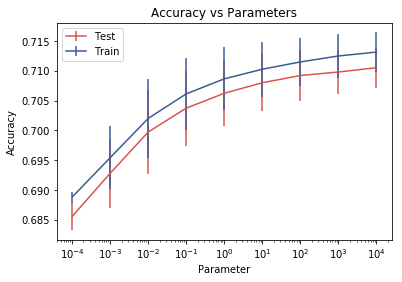

In [63]:
hyperParameterPlot(np.logspace(-4, 4, num=9),train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp)

The accuracy increases and confidence interval gets smaller as the value of hyperparameters increases.